## Demonstration of PairB&B trading automaton portfolio data used to train a random forest classifier.  

### nb: for brevity you may not be able to run all the cells and functions described in this notebook and only the outputs a copied over for your understanding 
### please make a copy of the so if you acedentily lose these outputs you can recover. 

In [1]:
import numpy as np
import pandas as pd

In [4]:
# modify below for the correct path
df_vpt_metrics=pd.read_csv('../../csv_files/vpt_metrics_SPY15m_no_features.csv', index_col=[0])

# DataFrame Column Descriptions

The dataframe .csv file vpt_metrics_SPY15m_no_features.csv contains results pertaining to 
15 monthly backtests perfromed using historical S&P500 data with the PairB&B trading automaton. 
The trader is designed to automatically select stocks from an input matrix of market instruments 
where the rows and cols represent respective prices at different dates for different instruments.
ideally the historical market data input to the automaton are related (eg. all same sector or country). 

For each monthly period, multiple hyper-settings that control the B&B trader are adjusted which changes the
way the trader behaves and as a result differnt stocks will be traded with differnt trading parameters and
the resultant portfolio over the same period will be different. Amongst other processing, the trader is just performing alot of backtests.
and most importantly the evaluation signal is always from unbiased test data. 
The automaton thus represents a layer of abstraction that can be used to simulate many automated trading scenerios
using a condensed set of hyper-parameters. 

Below provides detailed descriptions of the columns (trading hyperparameters and results) in the DataFrame. 

## Columns

1. **evaluation_timestep**  
   *the numerical indexing position on the historical dataframe used for evaluation.*

2. **eval_start_date**  
   *Start date stamp for the evaluation period* 

3. **eval_end_date**  
   *End date for the evaluation period*

4. **eval_length**  
   *Total Length of the evaluation period in days*

5. **signal_length**  
   *The duration of test signals i.e. if the signal length is 5 days and evaluation length is 20 days then 4 backtests are performed in total*

6. **holding_period**  
   *Duration for which a position is held based on the strategy*

7. **opt_entry_exit**  
   *trader will perfrom optimizations for entry and exit points using a simualted OU process (this can take a very long time), if set to false it will only optimize on historical data*

9. **pmwf**  
   *profit metrics with factor modeling*

10. **ur_1**  
   *uses spread ratios for z-scores during inital screening* 

11. **ur_signal**  
    *uses spread ratio for the final backtest*

12. **uhr**  
    *updates the hedge ratio ($w0$) when using a normal spread i.e. $S=P1-w0*P2$* 

13. **ufmfgs**  
    *use factor model for grid scan* 

14. **ctwof1**  
    *cointegration testing without factors 1*

15. **ctwof2**  
    *cointegration testing without factors 2*

16. **num_penu**  
    *truncate this number of penultimate entries from the principle eigenvector*

17. **penu_filter_thresh**  
    *overlap threshhold when filtering pairs based on position in the principle eigenvector*

18. **profit**  
    *final reletive profit (PNL value) calculated based on the strategy*
    
20. **sharpe**  
    *Sharpe ratio* 

21. **av_pnl**  
    *average PNL for evaluation period* 

22. **av_pnl_holding**  
    *Average PNL normalized by the holding period for the trades in the portfolio*

23. **stdev_pnl**  
    *standard deviation of pnl for evaluation period* 

---



In [5]:
df_vpt_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
evaluation_timestep,1373.0,547.150036,90.369645,400.000000,463.000000,549.000000,630.000000,693.000000
eval_length,1373.0,20.000000,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000
signal_length,1373.0,20.000000,0.000000,20.000000,20.000000,20.000000,20.000000,20.000000
holding_period,1373.0,15.908230,4.715711,0.000000,14.000000,17.000000,20.000000,20.000000
opt_entry_exit,1373.0,0.541151,0.498485,0.000000,0.000000,1.000000,1.000000,1.000000
pmwf,1373.0,0.495994,0.500166,0.000000,0.000000,0.000000,1.000000,1.000000
ur_1,1373.0,0.423889,0.494353,0.000000,0.000000,0.000000,1.000000,1.000000
ur_signal,1373.0,0.437728,0.496288,0.000000,0.000000,0.000000,1.000000,1.000000
uhr,1373.0,0.427531,0.494901,0.000000,0.000000,0.000000,1.000000,1.000000
ufmfgs,1373.0,0.648944,0.477474,0.000000,0.000000,1.000000,1.000000,1.000000


### Machine learning questions 

1.  Is there always a combination of hyperparameters that leads the positive PNL ??  
2.  Is there one combination of hyperparameters that generally helps to reduce risk and maintain a steady profit??
3.  If we supplement this backtesting data with other time-dependent features (eg. market indicies, exchage rates, econometric indicators ) can we predict which hyperparameter setting to use that will give us the best sharpe ratio or cash returns in the future ???

### EDA on pairB&B metrics dataframe 


In [7]:
# quesion 1.
# just making sure that for each month there was some combinttion that gave pnl>1.0
for et in df_vpt_metrics.evaluation_timestep.unique():
    print(f"evaluation_timestep: {et} max profit: {df_vpt_metrics[df_vpt_metrics.evaluation_timestep==et].profit.max()}, max sharpe: {df_vpt_metrics[df_vpt_metrics.evaluation_timestep==et].sharpe.max()}")

evaluation_timestep: 400 max profit: 1.1090974773778348, max sharpe: 3.791846293845136
evaluation_timestep: 422 max profit: 1.0476384120574145, max sharpe: 1.3175831366501414
evaluation_timestep: 443 max profit: 1.0417975321809645, max sharpe: 1.393096813971351
evaluation_timestep: 463 max profit: 1.092739466035206, max sharpe: 1.68309655767015
evaluation_timestep: 486 max profit: 1.0764367293317625, max sharpe: 2.0343259051296925
evaluation_timestep: 506 max profit: 1.1136071608227445, max sharpe: 1.958664991036919
evaluation_timestep: 528 max profit: 1.166971527471909, max sharpe: 3.145997506766051
evaluation_timestep: 549 max profit: 1.1357228906215855, max sharpe: 2.113868168077947
evaluation_timestep: 569 max profit: 1.111594126478043, max sharpe: 2.7966527394922744
evaluation_timestep: 590 max profit: 1.094628661214418, max sharpe: 2.9610872893535203
evaluation_timestep: 610 max profit: 1.0421807031170374, max sharpe: 1.842300501191388
evaluation_timestep: 630 max profit: 1.07788

#### The trader can be run is such a way that profit can always be positive and very high Sharpe can also be achieved   
but how to know which hyper parameters to use ??

##### This function is not included 
##### from CPO_functions.screening_functions import perform_sub_screening, get_combos_and_aggregate_screening_results_v2 
This function reads in the metric data and group/aggregates row entries based on a minimal set of configurations  
returning the average pnl and sharpe for all instances that have the same setings  

#### df_combos,df_combo_rankings=get_combos_and_aggregate_screening_results_v2(df_vpt_metrics, sort_rankings=True, df_combos=df_combos)
#### df_combos is constructed using itertools 


### df_combo_rankings
# Table: Data Summary


# Table: Performance Metrics

| Index |opt_entry_exit |pmwf   | ur_1      | ur_signal | uhr   | ufmfgs | ctwof1 | ctwof2 | av_profit | av_sharpe  | profitability | num_entries | sorting_rule           |
|-------|-------|-------|-------|-----------|----------|--------|--------|--------|-----------|------------|---------------|-------------|------------------------|
| 15    | False | False | True  |  False    |True      | True   | False   | False  | 1.007203  | 0.237026   | 0.666667      | 15          | profitability_profit   |
| 15    | False | False | True  |  False    |True      | True   | False   | False  | 1.007203  | 0.237026   | 0.666667      | 15          | profitability_sharpe   |
| 16    | False | False | True  |  False    |True      | False  | True  | True   | 1.010218  | 0.116665   | 0.533333      | 30          | av_profit              |
| 23    | False | True  | False |  False    |False     | True   | True   | False   | 1.006760  | 0.240825   | 0.533333      | 15          | av_sharpe              |
| 15    | False | False | True  |  False    |True      | True   | Fasle   | False  | 1.007203  | 0.237026   | 0.666667      | 15          | profitability          |



# Table:  Hyper Parameter Configuration

| Index | opt_entry_exit | pmwf | ur_1 | ur_signal | uhr | ufmfgs | ctwof1 | ctwof2 |
|-------|----------------|------|------|-----------|-----|--------|--------|--------|
| 15    | 0              | 0    | 1    | 0         | 1   | 1      | 0      | 0      |
| 15    | 0              | 0    | 1    | 0         | 1   | 1      | 0      | 0      |
| 16    | 0              | 0    | 1    | 0         | 1   | 0      | 1      | 1      |
| 23    | 0              | 1    | 0    | 0         | 0   | 1      | 1      | 0      |
| 15    | 0              | 0    | 1    | 0         | 1   | 1      | 0      | 0      |

So without fitting any models, just grouping and sorting  we can infer from the data that one reliable setting for av_profit is combination 16 





#### get factors to augment ML 
- becasue the backtests are perfromed on S&P500 market data we can add to the features some information based on the any date before the evaluation period  
- with functional trasformations, this could amount to alot so we are going also try to use PCA for dimensionality reduction
- to simplify the demonstration we will restrict to two indicies which might help represent the state of the market, the S&P500 index and the VIX  


In [ ]:

# if reading from saved csv file  

# spc_data = pd.read_csv('../../csv_files/GSPC_data_01Dec24.csv', parse_dates=True, header=[0,1], index_col=0)
# vix_data = pd.read_csv('../../csv_files/VIX_data_01Dec24.csv', parse_dates=True, header=[0,1], index_col=0)


# The function create_ML_features_from_price_data()  takes any timeseries data and then give you a corrsponding dataframe with selectid technical indicators 

# gspc_features = create_ML_features_from_price_data(gspc_data.xs(key='^GSPC',axis=1,level=1), prefix='gspc_', use_volume=True)
# vix_features = create_ML_features_from_price_data(vix_data.xs(key='^VIX',axis=1,level=1), prefix='vix_', use_volume=False)
# more processing ...
# df_pca_features.to_csv('../../csv_files/vpt_metrics_SPY15m_PCA1_features.csv',index=True)

### feature engineering to augment the backtesting metrics is performed as follow
1. both GSPC and VIX data for dates whicvh overlap our training and test blocks are downloaded
2. The timeseries data are used to generate a selection of technical indicators (eg. RSI, Bollinger bands, others)
3. The features are all merged and then PCA is performed
4. for evaluation date in the backtesting metrics block a vector of technical indicators (either vanilla or PCA) is appended  


In [9]:


path_to_csv='../../csv_files/vpt_metrics_SPY15m_PCA1_features.csv' 

df_list_res_all = pd.read_csv(path_to_csv, index_col=0)

print("df shape: ", df_list_res_all.shape)

print("replacing NaN sharpe ratios with zero!!")
sharpe_cols= list(df_list_res_all.columns[[True if 'sharpe' in col else False for col in  df_list_res_all.columns]])
for col in sharpe_cols: 
   df_list_res_all[col]= df_list_res_all[col].fillna(0.0)



df shape:  (1373, 28)
replacing NaN sharpe ratios with zero!!


In [10]:
df_list_res_all

,evaluation_timestep,eval_start_date,eval_end_date,eval_length,signal_length,holding_period,opt_entry_exit,pmwf,ur_1,ur_signal,...,av_pnl,av_pnl_holding,stdev_pnl,lb1_0,lb1_1,lb1_2,lb1_3,lb1_4,lb1_5,lb1_6
0,400,2023-05-01,2023-05-30,20,20,11,0,0,0,0,...,-0.031294,-0.017212,0.027144,2.252238,-1.047908,0.058688,-0.615344,0.073416,0.502331,0.001802
1,422,2023-06-01,2023-06-30,20,20,10,0,0,0,0,...,-0.002726,-0.001363,0.038343,0.364695,0.189937,0.705086,-0.607627,-0.356147,0.353439,0.092509
2,443,2023-07-03,2023-08-01,20,20,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.924326,0.132626,0.718457,-0.441160,-0.388243,0.190852,0.016129
3,463,2023-08-01,2023-08-29,20,20,0,0,0,0,0,...,0.000000,0.000000,0.000000,1.502716,0.487764,0.069847,-0.185357,-0.055734,0.276754,-0.544525
4,486,2023-09-01,2023-10-02,20,20,16,0,0,0,0,...,0.016751,0.013401,0.043411,1.452189,-1.821535,0.370764,-0.252933,0.570421,0.493473,-0.259290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,674,2024-06-03,2024-07-02,20,20,19,0,1,1,1,...,-0.026433,-0.025111,0.027865,0.456913,0.957272,-0.523312,0.106351,0.061309,0.460055,0.027845
1369,693,2024-07-01,2024-07-30,20,20,16,0,1,1,1,...,-0.024056,-0.019245,0.040368,1.211465,0.242680,0.090161,-0.949987,0.048855,0.040116,-0.041194
1370,652,2024-05-01,2024-05-30,20,20,16,1,1,1,1,...,0.030562,0.024449,0.045911,-1.048447,-0.665288,-0.494061,0.418101,1.454091,0.325470,0.289253
1371,674,2024-06-03,2024-07-02,20,20,20,1,1,1,1,...,-0.008686,-0.008686,0.024628,0.456913,0.957272,-0.523312,0.106351,0.061309,0.460055,0.027845


below pretty typical simple setup for trainig a classisfier
Ive evaluated a few  but for this demo just focus on the random forest  example

In [18]:
X = df_list_res_all.drop(['evaluation_timestep', 'eval_start_date', 'eval_end_date',
       'eval_length', 'signal_length', 'holding_period', 'profit', 'sharpe', 'av_pnl',
       'av_pnl_holding', 'stdev_pnl'],axis=1)

# note that if we make this cutoff too high then we will have unbalanced dataset
cutoff_sharpe=0.005
cutoff_profit=1.001
print("num_gt_cutoff_sharpe:", (df_list_res_all.sharpe > cutoff_sharpe).sum(), "num_gt_cutoff_profit:", (df_list_res_all.profit > cutoff_profit).sum())

# y obs is below 
y_sharpe=(df_list_res_all.sharpe > cutoff_sharpe).astype(int).reset_index(drop=True)
y_profit=(df_list_res_all.profit > cutoff_profit).astype(int).reset_index(drop=True)

print("features: ", X.columns)

# set random to None for differnt state each run
X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split(X, y_sharpe, test_size = 0.2, random_state = 42) 
print("size of holdout set:",len(y_test_sh))
print("size of training set:", len(y_train_sh))

X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X, y_profit, test_size = 0.2, random_state = 42) 
print("size of holdout set:",len(y_test_pr))
print("size of training set:", len(y_train_pr))

# decide on scaling the training data 
run_scaling=False
if run_scaling:
   print("Generating Scaled data from the training set!!")
   scaler = StandardScaler()
   X_train_scaled_sh = scaler.fit_transform(X_train_sh)
   X_test_scaled_sh = scaler.transform(X_test_sh)
   X_train_scaled_pr = scaler.fit_transform(X_train_pr)
   X_test_scaled_pr = scaler.transform(X_test_pr)
else:
   print("data remains unscaled!!")


num_gt_cutoff_sharpe: 527 num_gt_cutoff_profit: 503
features:  Index(['opt_entry_exit', 'pmwf', 'ur_1', 'ur_signal', 'uhr', 'ufmfgs',
       'ctwof1', 'ctwof2', 'num_penu', 'penu_filter_thresh', 'lb1_0', 'lb1_1',
       'lb1_2', 'lb1_3', 'lb1_4', 'lb1_5', 'lb1_6'],
      dtype='object')
size of holdout set: 275
size of training set: 1098
size of holdout set: 275
size of training set: 1098
data remains unscaled!!


### lots of classifiers are fit and then evaluated all at once  



Loading ../pickle/ens_clf_pca1feat_pr_SPY_small_RFC.pkl... 

Accuracy [TP / N]         Best: 1, Worst: 0: 
0.6654545454545454
precision: TP/TP+FP where FP = all misclasified in that column  
    recall:  TP/TP+FN where FN = all misclasified in that row 
    fscore:  harmonic mean of Precision and recall 
    support: sum each row in confusion matrix

[0.66960352 0.64583333]
[0.89940828 0.29245283]
[0.76767677 0.4025974 ]
[169 106]
ROC AUC scores <5 is bad
0.6839901752819024
Precision-recall AUC scores <5 is bad
0.5877920889101639

Loading ../pickle/ens_clf_pca1feat_pr_SPY_small_ada.pkl... 

Accuracy [TP / N]         Best: 1, Worst: 0: 
0.6509090909090909
precision: TP/TP+FP where FP = all misclasified in that column  
    recall:  TP/TP+FN where FN = all misclasified in that row 
    fscore:  harmonic mean of Precision and recall 
    support: sum each row in confusion matrix

[0.68159204 0.56756757]
[0.81065089 0.39622642]
[0.74054054 0.46666667]
[169 106]
ROC AUC scores <5 is bad
0.

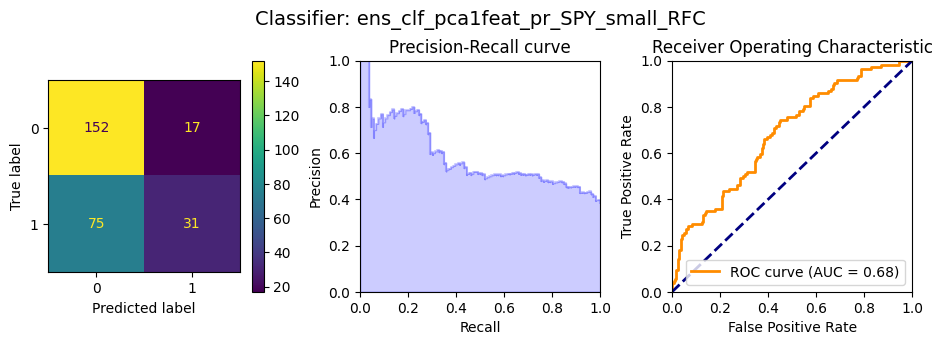

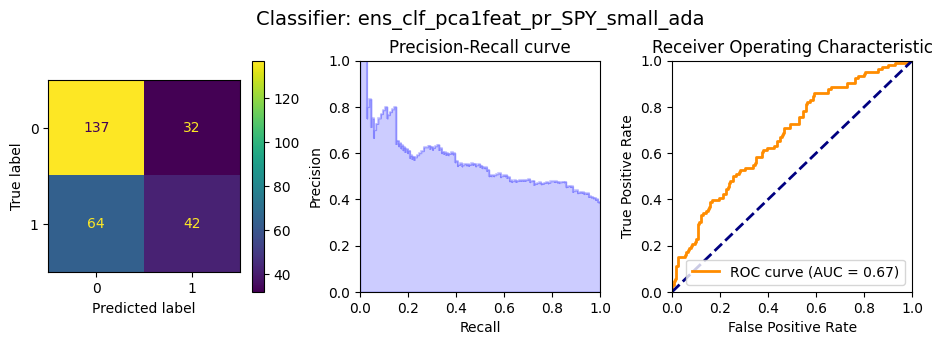

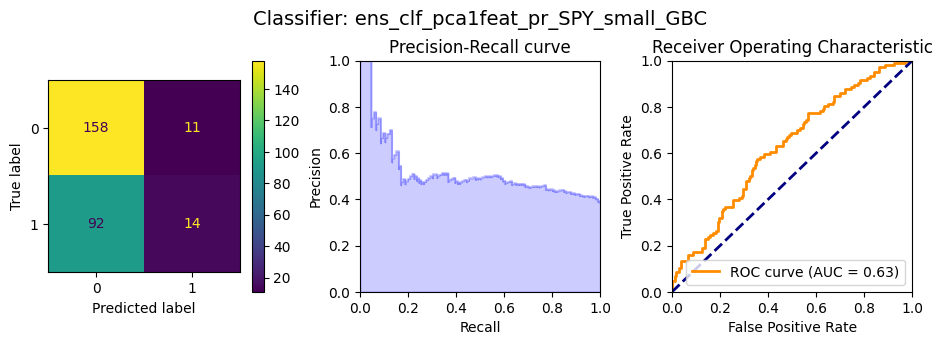

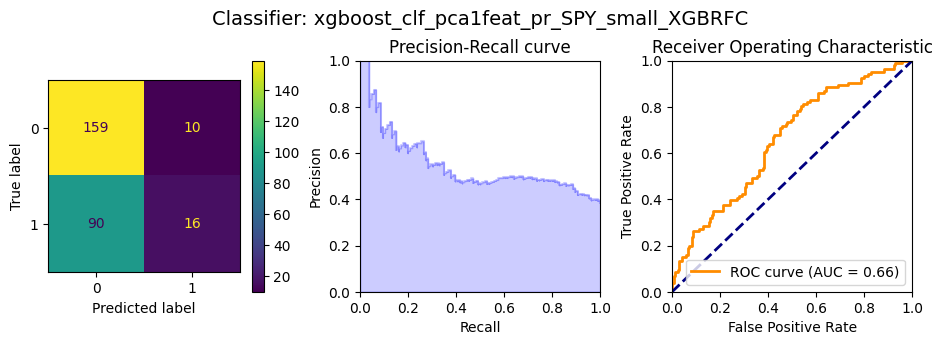

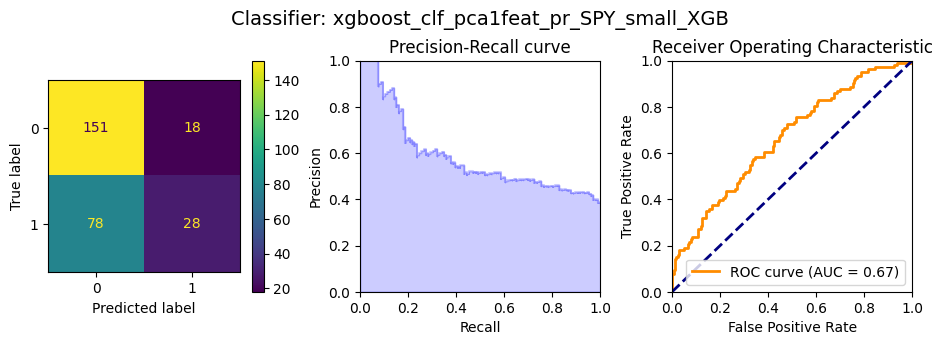

In [19]:
df_clf_res_pr, clf_best_pr = load_and_evaluate_clfs(X_test_pr, y_test_pr, 
                                              savepath='../pickle/', 
                                              classifiers=['ens_clf_pca1feat_pr_SPY_small_RFC', 
                                                           'ens_clf_pca1feat_pr_SPY_small_ada', 
                                                           'ens_clf_pca1feat_pr_SPY_small_GBC',
                                                           'xgboost_clf_pca1feat_pr_SPY_small_XGBRFC',
                                                           'xgboost_clf_pca1feat_pr_SPY_small_XGB'
                                                          ],
                                              return_best_model=True, make_plot=True)

In [59]:
df_clf_res_pr

,Accuracy,ROC AUC,Precision,Recall,F1 Score
ens_clf_pca1feat_pr_SPY_small_RFC,0.665455,0.683990,0.645833,0.292453,0.402597
ens_clf_pca1feat_pr_SPY_small_ada,0.650909,0.672714,0.567568,0.396226,0.466667
ens_clf_pca1feat_pr_SPY_small_GBC,0.625455,0.627386,0.560000,0.132075,0.213740
xgboost_clf_pca1feat_pr_SPY_small_XGBRFC,0.636364,0.657084,0.615385,0.150943,0.242424
xgboost_clf_pca1feat_pr_SPY_small_XGB,0.650909,0.665346,0.608696,0.264151,0.368421


### Feature importances 
notice how strongest features are in fact the model hyperparams

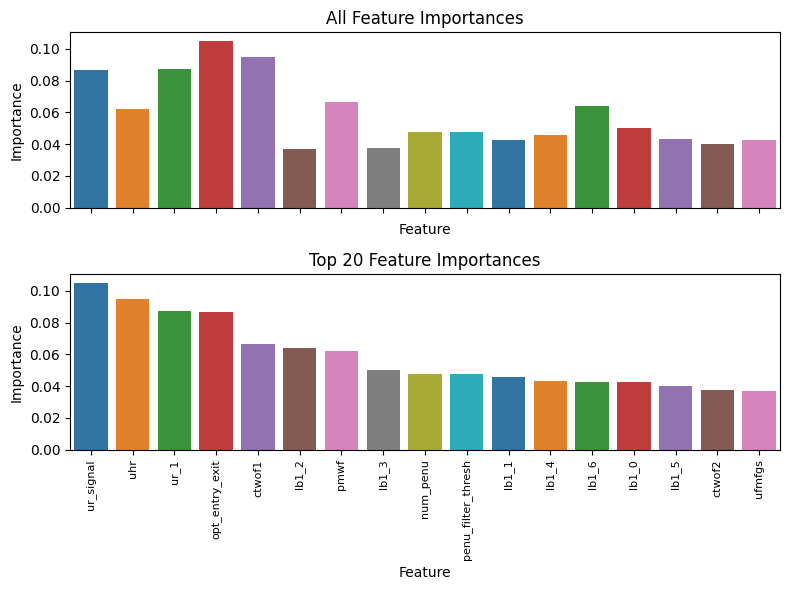

In [22]:
plot_feature_importances(clf_best_pr['ens_clf_pca1feat_pr_SPY_small_RFC'].named_steps['RFC'],X)

## investigate the RFC and ADA classifiers prediction probabilities 
- we want a bootstrap style testing for blocks of test data to output models prediction probabilities   
- construct each test block  using the diffent hyperparameter combinations and other features which represent
    a differnt market state. The latter parameters may not have as strong feature importances so may not influence the model
    indicating that the hyperparameters are somewhat robust
- we will do boot strap to try see just how robust the hyper parameters are at least in the context of a ML model attempting to predict future perfromance 


### below cell wont run in this notebook and the outputs are here so you get an idea of how the boot strapping works 
becasue i know the dates of whic I have the SP500 and VIX related feature data  ill just use the last 20 dates 
and add all the results to a big list . the combo which is the best is the first one 
so what you see is how the temporal features are changing the combiation to use to get the best probabilty (i.e. the probability we will get PNL > 1.001)
I know the threshold is small in term of profit but this is for data balance purposes casue im not a big fan of synthetic data to treat imbalancing  
I just want to see somthing 

In [68]:
res_list_ada=[]
for ds in features_dates_as_strings[-20:]:
    pred_block=get_pred_block_for_date(my_date_str=ds)
    df_pred_pr = pred_block.copy()
    df_pred_pr['profit_ada_prob'] = clf_best_pr['ens_clf_pca1feat_pr_SPY_small_ada'].predict_proba(pred_block)[:,1]
    df_pred_pr['profit_rfc_prob'] = clf_best_pr['ens_clf_pca1feat_pr_SPY_small_RFC'].predict_proba(pred_block)[:,1]
    res_list_ada.append(df_pred_pr.loc[:,['opt_entry_exit', 'pmwf', 'ur_1', 'ur_signal', 'uhr',  
                   'ufmfgs', 'ctwof1', 'ctwof2', 'num_penu', 'penu_filter_thresh',
                     'profit_ada_prob','profit_rfc_prob' ]].sort_values( 'profit_ada_prob',ascending=False).iloc[0])

In [69]:
res_list_rfc=[]
for ds in features_dates_as_strings[-20:]:
    pred_block=get_pred_block_for_date(my_date_str=ds)
    df_pred_pr = pred_block.copy()
    df_pred_pr['profit_ada_prob'] = clf_best_pr['ens_clf_pca1feat_pr_SPY_small_ada'].predict_proba(pred_block)[:,1]
    df_pred_pr['profit_rfc_prob'] = clf_best_pr['ens_clf_pca1feat_pr_SPY_small_RFC'].predict_proba(pred_block)[:,1]
    res_list_rfc.append(df_pred_pr.loc[:,['opt_entry_exit', 'pmwf', 'ur_1', 'ur_signal', 'uhr',  
                   'ufmfgs', 'ctwof1', 'ctwof2', 'num_penu', 'penu_filter_thresh',
                     'profit_ada_prob','profit_rfc_prob' ]].sort_values( 'profit_rfc_prob',ascending=False).iloc[0])

In [71]:
pd.DataFrame(res_list_ada)

,opt_entry_exit,pmwf,ur_1,ur_signal,uhr,ufmfgs,ctwof1,ctwof2,num_penu,penu_filter_thresh,profit_ada_prob,profit_rfc_prob
122,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.15,0.20,0.718420,0.503251
122,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.15,0.20,0.693106,0.496379
98,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.20,0.25,0.642299,0.411238
29,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.20,0.25,0.689014,0.504710
57,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.15,0.20,0.646228,0.384864
57,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.15,0.20,0.669072,0.444076
57,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.15,0.20,0.617090,0.452992
17,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.15,0.20,0.624197,0.409649
40,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.15,0.20,0.641490,0.493537
28,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.20,0.25,0.671655,0.575696


In [72]:
pd.DataFrame(res_list_rfc)

,opt_entry_exit,pmwf,ur_1,ur_signal,uhr,ufmfgs,ctwof1,ctwof2,num_penu,penu_filter_thresh,profit_ada_prob,profit_rfc_prob
114,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.20,0.25,0.577551,0.612090
114,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.20,0.25,0.567636,0.584185
40,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.15,0.20,0.610346,0.457094
44,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.20,0.25,0.630115,0.543755
44,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.20,0.25,0.569875,0.524504
43,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.20,0.25,0.396041,0.478025
57,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.15,0.20,0.617090,0.452992
16,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.15,0.20,0.586708,0.477374
16,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.15,0.20,0.582461,0.509705
99,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.20,0.25,0.558675,0.610473


### important ... what is  frequency of which combinations top ranked ??  

In [78]:
 pd.DataFrame(res_list_ada).index.value_counts()

28     6
57     4
122    2
29     2
52     2
98     1
17     1
40     1
86     1
Name: count, dtype: int64

In [79]:
pd.DataFrame(res_list_rfc).index.value_counts()

28     5
40     3
16     3
99     3
114    2
44     2
43     1
57     1
Name: count, dtype: int64

## conclusion 

The workflow appears logical. 
still very unclear if PCA is making any improvment. 


the combo 28 appears to align well with the results from the  EDA modeling for most consistant average profit, 
this was  surprisingly sensical if we assume feature importance are robust.  

this somewhat loosly identifies a parameter setting that in general cound be used to  
to run the trader atomatically with reduced risk and maintain a steady profit??
however ideally we want to know which settings could be used to maximize profit and also perhaps if no trading should be perfromed 
(i.e. black swan detection - i think this is hopefully optimistic) 

Next step is to move formard with setting the test of automated order excecution, which mean using API to communicate with exchange 
and simmualting real automated orders, etc...  
